In [1]:
from synthetix_v3.base_perps import BasePerps
from datetime import datetime
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
base_perp = BasePerps()

### get market info

In [3]:
market_price_df = base_perp.get_market_updates()

In [4]:
market_price_df.columns

Index(['marketUpdateds_timestamp', 'markets_id', 'marketUpdateds_price',
       'marketUpdateds_skew', 'marketUpdateds_size',
       'marketUpdateds_sizeDelta', 'marketUpdateds_currentFundingRate',
       'marketUpdateds_currentFundingVelocity', 'markets_marketSymbol'],
      dtype='object')

In [5]:
market_price_polars_df = pl.from_pandas(market_price_df).with_columns([
    pl.from_epoch('marketUpdateds_timestamp').dt.round("1s").alias('datetime'),
    pl.col('marketUpdateds_price') / 10**18,
    pl.col('marketUpdateds_skew') / 10**18,
    pl.col('marketUpdateds_size') / 10**18,
    pl.col('marketUpdateds_sizeDelta') / 10**18,
    pl.col('marketUpdateds_currentFundingRate') / 10**18,
    pl.col('marketUpdateds_currentFundingVelocity') / 10**18
])

In [6]:
market_price_polars_df.head(5)

marketUpdateds_timestamp,markets_id,marketUpdateds_price,marketUpdateds_skew,marketUpdateds_size,marketUpdateds_sizeDelta,marketUpdateds_currentFundingRate,marketUpdateds_currentFundingVelocity,markets_marketSymbol,datetime
i64,i64,f64,f64,f64,f64,f64,f64,str,datetime[μs]
1697330062,100,1552.147774,-7561.418437,19128.58898,-615.0024,0.008701,-0.068053,"""ETH""",2023-10-15 00:34:22
1697325288,100,1556.300977,-6946.416037,19743.59138,1284.8751,0.012155,-0.062518,"""ETH""",2023-10-14 23:14:48
1697321028,300,7.308,-6688.146558,33222.967442,-6823.8774,-0.004412,-0.012039,"""LINK""",2023-10-14 22:03:48
1697318570,300,7.32966,135.730842,40046.844842,6823.8774,-0.004419,0.000244,"""LINK""",2023-10-14 21:22:50
1697317636,100,1558.04251,-8231.291137,21028.46648,1561.9509,0.018716,-0.074082,"""ETH""",2023-10-14 21:07:16


### get position liquidations

In [7]:
pos_liqs_df = base_perp.get_position_liquidations()

In [8]:
position_liquidations_df = pl.from_pandas(pos_liqs_df)

In [9]:
position_liquidations_df = position_liquidations_df.with_columns([
    pl.from_epoch('positionLiquidateds_timestamp').dt.round("1s").alias('datetime'),
    pl.col('positionLiquidateds_amountLiquidated') / 10**18,
    pl.col('positionLiquidateds_currentPositionSize') / 10**18,
    ]).filter(pl.col("datetime") > datetime(2023, 10, 2))

In [10]:
joined_data = position_liquidations_df.join(market_price_polars_df, on='datetime', how='left')

In [11]:
print(position_liquidations_df.shape)
print(market_price_polars_df.shape)

(154, 8)
(2344, 10)


In [12]:
joined_subset_data = joined_data.select(
    'datetime', 
    'markets_marketSymbol', 
    'positionLiquidateds_accountId', 
    'positionLiquidateds_amountLiquidated', 
    'positionLiquidateds_currentPositionSize', 
    'marketUpdateds_price'
    ).with_columns([
        (pl.col('marketUpdateds_price') * pl.col('positionLiquidateds_amountLiquidated')).alias('amountLiquidated_usd'),
        (pl.col('marketUpdateds_price') * pl.col('positionLiquidateds_currentPositionSize')).alias('currentPoisitionSize_usd')
        ]).sort(by='datetime', descending=True)

### Look at Liquidation for a single Account

In [16]:
account_liquidation = joined_subset_data.filter(pl.col('positionLiquidateds_accountId') == 69)

In [17]:
account_liquidation

datetime,markets_marketSymbol,positionLiquidateds_accountId,positionLiquidateds_amountLiquidated,positionLiquidateds_currentPositionSize,marketUpdateds_price,amountLiquidated_usd,currentPoisitionSize_usd
datetime[μs],str,f64,f64,f64,f64,f64,f64
2023-10-13 21:04:44,"""ETH""",69.0,450.028,0.0,1573.225,707995.3003,0.0
2023-10-13 21:04:04,"""ETH""",69.0,699.993,-450.028,1571.819924,1.1003e6,-707362.976654
2023-10-13 21:03:24,"""ETH""",69.0,699.993,-1150.021,1570.6125,1.0994e6,-1.8062e6
2023-10-13 21:02:44,"""ETH""",69.0,699.993,-1850.014,1571.943055,1.1003e6,-2.9081e6
2023-10-13 21:02:06,"""ETH""",69.0,699.993,-2550.007,1569.7125,1.0988e6,-4.0028e6


In [18]:
# get first and last datetime stamp
first_datetime = account_liquidation.select('datetime').tail(1).item()
last_datetime = account_liquidation.select('datetime').head(1).item()

# get first and last price
first_price = account_liquidation.select('marketUpdateds_price').tail(1).item()
last_price = account_liquidation.select('marketUpdateds_price').head(1).item()

In [19]:
# print first and last datetime
print(first_datetime)
print(last_datetime)

2023-10-13 21:02:06
2023-10-13 21:04:44


In [20]:
time_range = last_datetime - first_datetime
price_range = first_price - last_price
liq_amount = account_liquidation.select('positionLiquidateds_amountLiquidated').sum().item()
account_liquidation.select('positionLiquidateds_currentPositionSize').tail(1).item()

# print the date_range as a string
print(f"Date range: {time_range}m")
print(f"Price range: ${price_range:,.2f}")
print(f'Starting position size: {account_liquidation.select("currentPoisitionSize_usd").tail(1).item():,.2f} ETH')
print(f'Amount liquidated: {liq_amount:,.2f} ETH')

Date range: 0:02:38m
Price range: $-3.51
Starting position size: -4,002,777.86 ETH
Amount liquidated: 3,250.00 ETH


### Bar plot of market liquidations

In [25]:
grouped_df = (
    position_liquidations_df.sort(by="datetime", descending=True)
    .with_columns(pl.col("datetime").dt.round("1d"))
    .group_by("datetime", "markets_marketSymbol")
    .agg([pl.count()])
    .filter(pl.col("datetime") > datetime(2023, 10, 2))
)

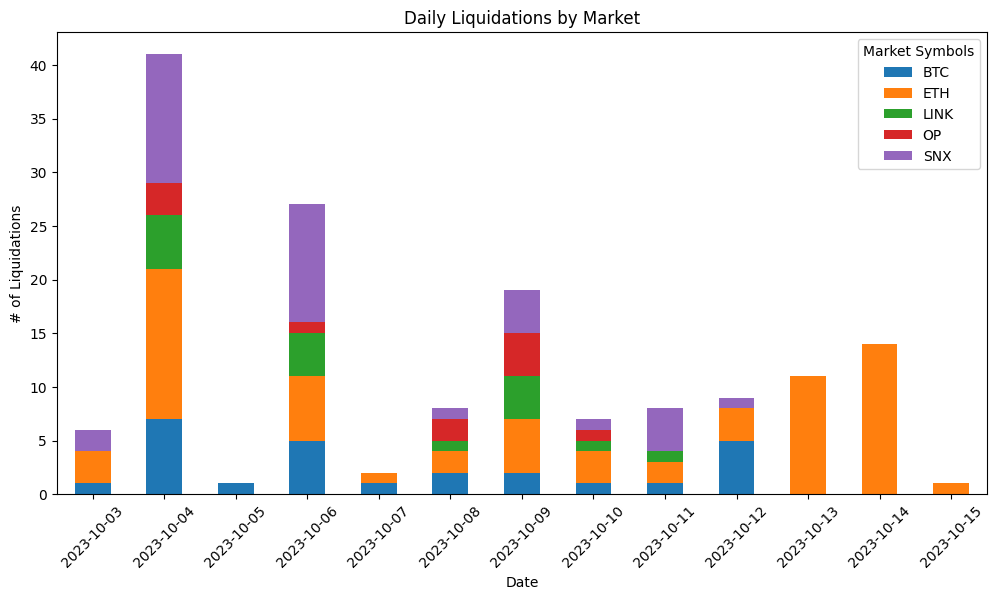

In [26]:
# Pivot the DataFrame to create a stacked bar plot
pivot_df = grouped_df.to_pandas().pivot(index='datetime', columns='markets_marketSymbol', values='count').fillna(0)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
pivot_df.plot(kind='bar', stacked=True, ax=ax)

ax.set_xlabel("Date")
ax.set_ylabel("# of Liquidations")
ax.set_title("Daily Liquidations by Market")

# Format the x-axis labels to display only the date
date_format = mdates.DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(date_format)

plt.xticks(range(len(pivot_df.index)), [ts.strftime('%Y-%m-%d') for ts in pivot_df.index], rotation=45)
plt.legend(title="Market Symbols")
plt.show()